# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"


# TensorFlow ≥2.0-preview is required
import tensorflow as tf
from tensorflow import keras
if tf.__version__ < "2.0":
    if keras.__version__ < "2.0":
        raise AssertionError("Keras version is too low")
    

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "ann"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

In [2]:
print(tf.__version__)
print(keras.__version__)

2.0.0-rc1
2.2.4-tf


# Perceptrons

**Note**: we set `max_iter` and `tol` explicitly to avoid warnings about the fact that their default value will change in future versions of Scikit-Learn.

In [3]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0).astype(np.int) # Iris Setosa?

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [4]:
y_pred

array([1])

In [5]:
per_clf.coef_

array([[-1.4, -2.2]])

Saving figure perceptron_iris_plot


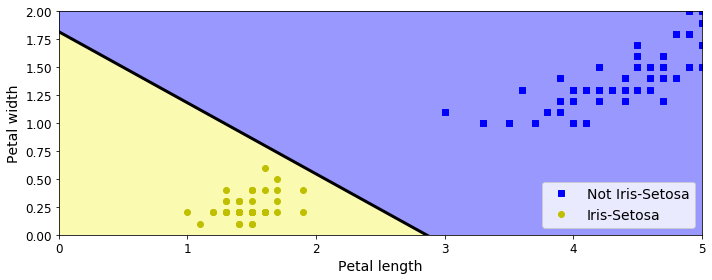

In [6]:
# y = alph0 + alph1*x1 + alph2*x2
# 0 = alph0 +  alph1*x1 + alph2*x2
# x2 = -(alph0/alph2)*x1 -(alpha1/alpha2)
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

save_fig("perceptron_iris_plot")
plt.show()

# Activation functions

In [7]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

Saving figure activation_functions_plot


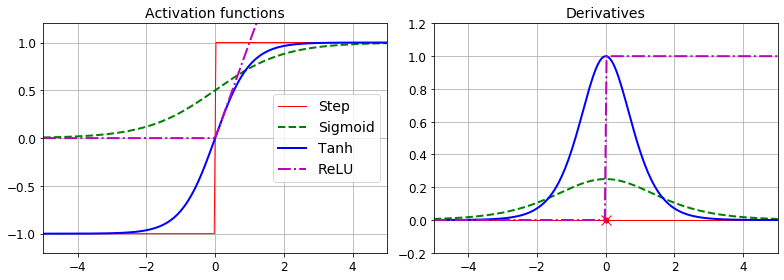

In [8]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])

save_fig("activation_functions_plot")
plt.show()

![Figure 10-6](https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure10_6.png?raw=true)

Above is XOR classification problem and an MLP that solves it in the book and let us implement it.

In [9]:
def heaviside(z):  # same as np.sign(), i.e., step function
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

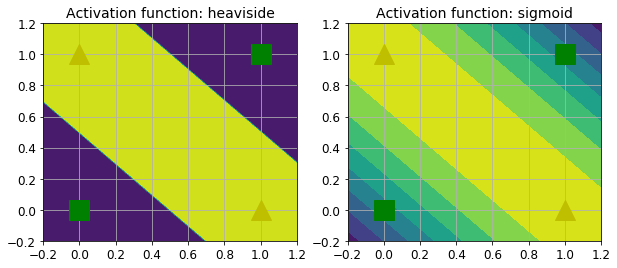

In [10]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

# Building an Image Classifier

First let's import `TensorFlow` and `Keras`

In [11]:
import tensorflow as tf
from tensorflow import keras

In [12]:
tf.__version__, keras.__version__

('2.0.0-rc1', '2.2.4-tf')

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [13]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [14]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [15]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [16]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

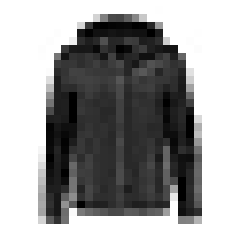

In [17]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [18]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

In [19]:
y_train.shape

(55000,)

In [20]:
classes, counts = np.unique(y_train, return_counts=True)

In [21]:
print("class counts")
for class_, count in zip(classes, counts):
    print(f'{class_:>3}{count:>8}')

class counts
  0    5543
  1    5444
  2    5496
  3    5499
  4    5512
  5    5507
  6    5507
  7    5488
  8    5510
  9    5494


Here are the corresponding class names:

In [22]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [23]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [24]:
X_valid.shape

(5000, 28, 28)

In [25]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

Saving figure fashion_mnist_plot


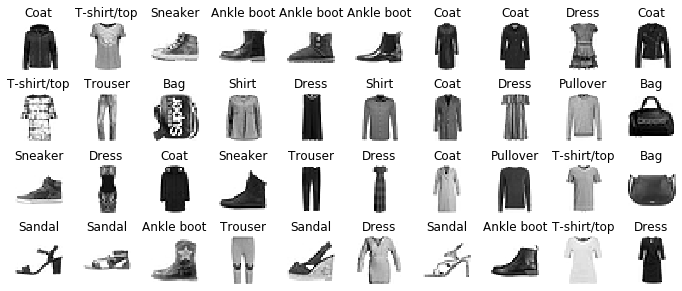

In [26]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_plot', tight_layout=False)
plt.show()

In [27]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

In [28]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [29]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [30]:
model.layers

In [31]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [32]:
#  W = (784 x 300), b = (300,)
300*784 + 500

235700

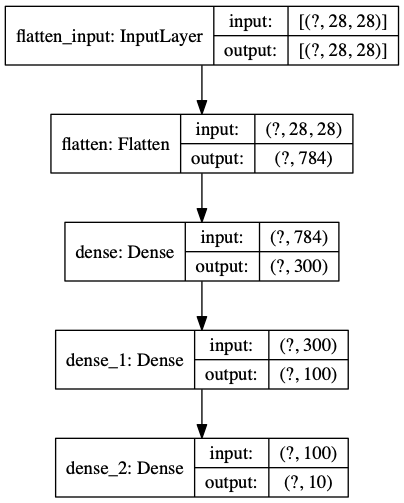

In [33]:
keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

In [34]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [35]:
model.get_layer(hidden1.name) is hidden1

True

In [36]:
weights, biases = hidden1.get_weights()

In [37]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [38]:
weights.shape

(784, 300)

In [39]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [40]:
biases.shape

(300,)

In [41]:
hidden1.get_config()

{'name': 'dense',
 'trainable': True,
 'dtype': 'float32',
 'units': 300,
 'activation': 'relu',
 'use_bias': True,
 'kernel_initializer': {'class_name': 'GlorotUniform',
  'config': {'seed': None}},
 'bias_initializer': {'class_name': 'Zeros', 'config': {}},
 'kernel_regularizer': None,
 'bias_regularizer': None,
 'activity_regularizer': None,
 'kernel_constraint': None,
 'bias_constraint': None}

In [42]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="sgd",
              metrics=["accuracy"])

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

In [43]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 3s 54us/sample - loss: 0.7228 - accuracy: 0.7623 - val_loss: 0.5304 - val_accuracy: 0.8160
Epoch 2/30
55000/55000 [==============================] - 2s 44us/sample - loss: 0.4838 - accuracy: 0.8323 - val_loss: 0.4494 - val_accuracy: 0.8454
Epoch 3/30
55000/55000 [==============================] - 2s 45us/sample - loss: 0.4379 - accuracy: 0.8475 - val_loss: 0.4173 - val_accuracy: 0.8548
Epoch 4/30
55000/55000 [==============================] - 2s 43us/sample - loss: 0.4126 - accuracy: 0.8555 - val_loss: 0.3898 - val_accuracy: 0.8660
Epoch 5/30
55000/55000 [==============================] - 2s 45us/sample - loss: 0.3930 - accuracy: 0.8626 - val_loss: 0.3987 - val_accuracy: 0.8610
Epoch 6/30
55000/55000 [==============================] - 3s 52us/sample - loss: 0.3776 - accuracy: 0.8672 - val_loss: 0.3730 - val_accuracy: 0.8732
Epoch 7/30
55000/55000 [==============================] -

In [44]:
history.params

{'batch_size': 32,
 'epochs': 30,
 'steps': 1719,
 'samples': 55000,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

In [45]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [46]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

Saving figure keras_learning_curves_plot


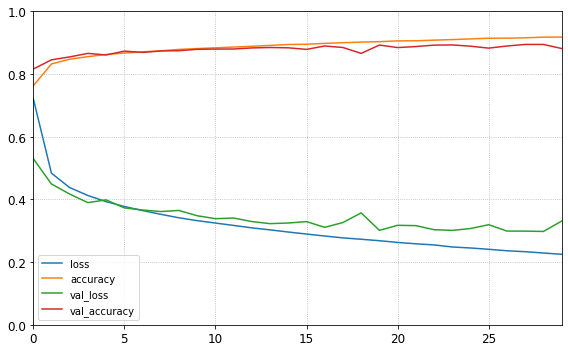

In [47]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.grid(linestyle=':')
save_fig("keras_learning_curves_plot")
plt.show()

In [48]:
model.evaluate(X_test, y_test, verbose=0)

[0.36434496695995333, 0.8681]

In [49]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.01, 0.  , 0.98],
       [0.  , 0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

In [50]:
y_pred = model.predict_classes(X_new)
y_pred

array([9, 2, 1])

In [51]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [52]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

Saving figure fashion_mnist_images_plot


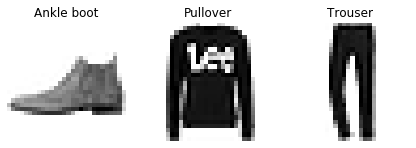

In [53]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
save_fig('fashion_mnist_images_plot', tight_layout=False)
plt.show()

# Regression MLP

Let's load, split and scale the `California housing dataset` (the original one, not the modified one as in chapter 2):

In [54]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [55]:
np.random.seed(42)
tf.random.set_seed(42)

In [56]:
X_train.shape

(11610, 8)

In [57]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test, verbose=0)

X_new = X_test[:3]
y_pred = model.predict(X_new)
mse_test

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 3s 224us/sample - loss: 1.6321 - val_loss: 1.5903
Epoch 2/20
11610/11610 [==============================] - 2s 136us/sample - loss: 0.7124 - val_loss: 0.6539
Epoch 3/20
11610/11610 [==============================] - 2s 135us/sample - loss: 0.6348 - val_loss: 0.6039
Epoch 4/20
11610/11610 [==============================] - 2s 133us/sample - loss: 0.5983 - val_loss: 0.5738
Epoch 5/20
11610/11610 [==============================] - 2s 139us/sample - loss: 0.5713 - val_loss: 0.5406
Epoch 6/20
11610/11610 [==============================] - 2s 150us/sample - loss: 0.5482 - val_loss: 0.5221
Epoch 7/20
11610/11610 [==============================] - 2s 147us/sample - loss: 0.5298 - val_loss: 0.4965
Epoch 8/20
11610/11610 [==============================] - 1s 128us/sample - loss: 0.5138 - val_loss: 0.4843
Epoch 9/20
11610/11610 [==============================] - 1s 119us/sample - loss: 0.500

0.4219739536906398

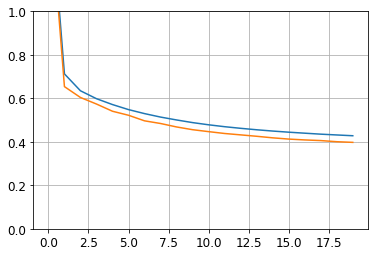

In [58]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [59]:
y_pred

array([[0.36892918],
       [1.6819053 ],
       [3.0886497 ]], dtype=float32)

# Functional API

Not all neural network models are simply sequential. Some may have complex topologies. Some may have multiple inputs and/or multiple outputs. For example, a Wide & Deep neural network (see [paper](https://ai.google/research/pubs/pub45413)) connects all or part of the inputs directly to the output layer.

![Figure 10-13](https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure10-13.png?raw=true)

Let’s build such a neural network to tackle the California housing problem:

In [60]:
np.random.seed(42)
tf.random.set_seed(42)

In [61]:
input_ = keras.layers.Input(shape=X_train.shape[1:])
# As soon as it is created, notice that we call it like a function, passing it the input. 
# This is why this is called the Functional API
hidden1 = keras.layers.Dense(30, activation="relu")(input_)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_, hidden2])
# create the output layer, with a single neuron and no activation function
output = keras.layers.Dense(1)(concat)
model = keras.models.Model(inputs=[input_], outputs=[output])

In [62]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_5 (Dense)                 (None, 30)           270         input_1[0][0]                    
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 30)           930         dense_5[0][0]                    
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, 38)           0           input_1[0][0]                    
                                                                 dense_6[0][0]                

In [63]:
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test, verbose=0)
y_pred = model.predict(X_new)

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 2s 136us/sample - loss: 1.2474 - val_loss: 0.8727
Epoch 2/20
11610/11610 [==============================] - 1s 75us/sample - loss: 0.6341 - val_loss: 0.8881
Epoch 3/20
11610/11610 [==============================] - 1s 82us/sample - loss: 0.5885 - val_loss: 0.5573
Epoch 4/20
11610/11610 [==============================] - 1s 79us/sample - loss: 0.5599 - val_loss: 0.5238
Epoch 5/20
11610/11610 [==============================] - 1s 80us/sample - loss: 0.5367 - val_loss: 0.6201
Epoch 6/20
11610/11610 [==============================] - 1s 81us/sample - loss: 0.5170 - val_loss: 0.4979
Epoch 7/20
11610/11610 [==============================] - 1s 79us/sample - loss: 0.5022 - val_loss: 0.5240
Epoch 8/20
11610/11610 [==============================] - 1s 75us/sample - loss: 0.4885 - val_loss: 0.4538
Epoch 9/20
11610/11610 [==============================] - 1s 76us/sample - loss: 0.4778 - val_

In [64]:
mse_test

0.4045557499855988

In [65]:
y_pred

array([[0.4686121],
       [1.8569269],
       [3.340442 ]], dtype=float32)

What if you want to send different subsets of input features through the wide or deep paths? We will send 5 features (features 0 to 4), and 6 through the deep path (features 2 to 7). Note that 3 features will go through both (features 2, 3 and 4).

![Figure 10-14](https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure10_14.png?raw=true)

In [66]:
np.random.seed(42)
tf.random.set_seed(42)

In [67]:
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")
hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)
concat = keras.layers.concatenate([input_A, hidden2])
output = keras.layers.Dense(1, name="output")(concat)
model = keras.models.Model(inputs=[input_A, input_B], outputs=[output])

In [68]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

X_train_A, X_train_B = X_train[:, :5], X_train[:, 2:]
X_valid_A, X_valid_B = X_valid[:, :5], X_valid[:, 2:]
X_test_A, X_test_B = X_test[:, :5], X_test[:, 2:]
X_new_A, X_new_B = X_test_A[:3], X_test_B[:3]

history = model.fit((X_train_A, X_train_B), y_train, epochs=20,
                    validation_data=((X_valid_A, X_valid_B), y_valid))
mse_test = model.evaluate((X_test_A, X_test_B), y_test, verbose=0)
y_pred = model.predict((X_new_A, X_new_B))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 90us/sample - loss: 1.8095 - val_loss: 1.4409
Epoch 2/20
11610/11610 [==============================] - 1s 57us/sample - loss: 0.6798 - val_loss: 0.6123
Epoch 3/20
11610/11610 [==============================] - 1s 56us/sample - loss: 0.5957 - val_loss: 0.5618
Epoch 4/20
11610/11610 [==============================] - 1s 55us/sample - loss: 0.5580 - val_loss: 0.5514
Epoch 5/20
11610/11610 [==============================] - 1s 57us/sample - loss: 0.5331 - val_loss: 0.5073
Epoch 6/20
11610/11610 [==============================] - 1s 58us/sample - loss: 0.5124 - val_loss: 0.4860
Epoch 7/20
11610/11610 [==============================] - 1s 52us/sample - loss: 0.4972 - val_loss: 0.4631
Epoch 8/20
11610/11610 [==============================] - 1s 51us/sample - loss: 0.4834 - val_loss: 0.4514
Epoch 9/20
11610/11610 [==============================] - 1s 50us/sample - loss: 0.4746 - val_l

In [69]:
mse_test

0.4249315629633822

In [70]:
y_pred

array([[0.2949911],
       [1.9546194],
       [3.4345765]], dtype=float32)

Another use case is as a regularization technique (i.e., a training constraint whose objective is to reduce overfitting and thus improve the model’s ability to generalize). For example, you may want to add some auxiliary outputs in a neural network architecture  to ensure that the underlying part of the network learns something useful on its own, without relying on the rest of the network.

Adding an auxiliary output for regularization:

![Figure 10-15](https://github.com/soo-pecialist/Hands_on_ML_w_Scikit_Karas_and_TensorFlow/blob/master/images_used/figure10_15.png?raw=true)

In [71]:
np.random.seed(42)
tf.random.set_seed(42)

In [72]:
# Beware of input at each layer
input_A = keras.layers.Input(shape=[5], name="wide_input")
input_B = keras.layers.Input(shape=[6], name="deep_input")

hidden1 = keras.layers.Dense(30, activation="relu")(input_B)
hidden2 = keras.layers.Dense(30, activation="relu")(hidden1)

concat = keras.layers.concatenate([input_A, hidden2])

output = keras.layers.Dense(1, name="main_output")(concat)
aux_output = keras.layers.Dense(1, name="aux_output")(hidden2)

# specify that we have 2 inputs and 2 outputs
model = keras.models.Model(inputs=[input_A, input_B],
                           outputs=[output, aux_output])

Each output will need its own loss function, so when we compile the model we should pass a list of losses (if we pass a single loss, Keras will assume that the same loss must be used for all outputs). By default, Keras will compute all these losses and __simply add them up to get the final loss used for training__. However, we __care much more about the main output__ than about the auxiliary output (as it is just used for regularization), so we want to give the main output’s loss a much __greater weight__. Fortunately, it is possible to set all the loss weights when compiling the model:

In [73]:
model.compile(loss=["mse", "mse"], 
              loss_weights=[0.9, 0.1], 
              optimizer=keras.optimizers.SGD(lr=1e-3))

In [74]:
# note that now we feed [y_valid, y_valid] at `validation_data`
history = model.fit([X_train_A, X_train_B], [y_train, y_train], 
                    epochs=20,
                    validation_data=([X_valid_A, X_valid_B], [y_valid, y_valid]))

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 97us/sample - loss: 2.1329 - main_output_loss: 1.9166 - aux_output_loss: 4.0719 - val_loss: 2.2885 - val_main_output_loss: 1.5657 - val_aux_output_loss: 8.7861
Epoch 2/20
11610/11610 [==============================] - 1s 51us/sample - loss: 0.8910 - main_output_loss: 0.6989 - aux_output_loss: 2.6202 - val_loss: 1.4258 - val_main_output_loss: 0.6285 - val_aux_output_loss: 8.5972
Epoch 3/20
11610/11610 [==============================] - 1s 51us/sample - loss: 0.7397 - main_output_loss: 0.6064 - aux_output_loss: 1.9374 - val_loss: 1.3894 - val_main_output_loss: 0.5941 - val_aux_output_loss: 8.5417
Epoch 4/20
11610/11610 [==============================] - 1s 52us/sample - loss: 0.6746 - main_output_loss: 0.5684 - aux_output_loss: 1.6301 - val_loss: 1.3275 - val_main_output_loss: 0.6028 - val_aux_output_loss: 7.8451
Epoch 5/20
11610/11610 [==============================] - 1s 55us/s

When we evaluate the model, Keras will return the total loss, as well as all the individual losses:

In [75]:
total_loss, main_loss, aux_loss = model.evaluate([X_test_A, X_test_B], [y_test, y_test],
                                                verbose=0)
y_pred_main, y_pred_aux = model.predict([X_new_A, X_new_B])

In [76]:
total_loss, main_loss, aux_loss

(0.4683263566142829, 0.41918433, 0.91364497)

In [77]:
y_pred_main

array([[0.25949997],
       [1.9820837 ],
       [3.3337932 ]], dtype=float32)

In [78]:
y_pred_aux

array([[0.9526369],
       [1.9273019],
       [2.5151913]], dtype=float32)

# The subclassing API

Some models involve loops, varying shapes, conditional branching, and other dynamic behaviors. For such cases, or simply if you prefer a more impera‐ tive programming style, the Subclassing API is for you.

Simply subclass the `Model` class, create the layers you need in the constructor, and use them to perform the computations you want in the `call()` method. For example, creating an instance of the following `WideAndDeepModel` class gives us an equivalent model to the one we just built with the Functional API. You can then compile it, evaluate it and use it to make predictions, exactly like we just did.

In [79]:
class WideAndDeepModel(keras.models.Model):
    def __init__(self, units=30, activation="relu", **kwargs):
        super().__init__(**kwargs)
        self.hidden1 = keras.layers.Dense(units, activation=activation)
        self.hidden2 = keras.layers.Dense(units, activation=activation)
        self.main_output = keras.layers.Dense(1)
        self.aux_output = keras.layers.Dense(1)
        
    def call(self, inputs):
        input_A, input_B = inputs
        hidden1 = self.hidden1(input_B)
        hidden2 = self.hidden2(hidden1)
        concat = keras.layers.concatenate([input_A, hidden2])
        main_output = self.main_output(concat)
        aux_output = self.aux_output(hidden2)
        return main_output, aux_output

model = WideAndDeepModel(30, activation="relu")

In [80]:
# same as before
model.compile(loss="mse", 
              loss_weights=[0.9, 0.1], 
              optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit((X_train_A, X_train_B), (y_train, y_train), epochs=10,
                    validation_data=((X_valid_A, X_valid_B), (y_valid, y_valid)))
total_loss, main_loss, aux_loss = model.evaluate((X_test_A, X_test_B), 
                                                 (y_test, y_test),
                                                 verbose=0)
y_pred_main, y_pred_aux = model.predict((X_new_A, X_new_B))

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 112us/sample - loss: 2.2968 - output_1_loss: 2.1826 - output_2_loss: 3.3166 - val_loss: 3.0093 - val_output_1_loss: 1.5519 - val_output_2_loss: 16.1139
Epoch 2/10
11610/11610 [==============================] - 1s 52us/sample - loss: 0.9760 - output_1_loss: 0.8529 - output_2_loss: 2.0834 - val_loss: 1.9290 - val_output_1_loss: 0.7524 - val_output_2_loss: 12.5119
Epoch 3/10
11610/11610 [==============================] - 1s 53us/sample - loss: 0.8288 - output_1_loss: 0.7270 - output_2_loss: 1.7431 - val_loss: 1.6768 - val_output_1_loss: 0.7256 - val_output_2_loss: 10.2305
Epoch 4/10
11610/11610 [==============================] - 1s 50us/sample - loss: 0.7637 - output_1_loss: 0.6744 - output_2_loss: 1.5665 - val_loss: 1.4544 - val_output_1_loss: 0.6860 - val_output_2_loss: 8.3638
Epoch 5/10
11610/11610 [==============================] - 1s 52us/sample - loss: 0.7227 - output_1_loss

In [81]:
model = WideAndDeepModel(30, activation="relu")

# Saving and Restoring

In [82]:
np.random.seed(42)
tf.random.set_seed(42)

In [83]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

In [84]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test, verbose = 0)
mse_test

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 65us/sample - loss: 1.8631 - val_loss: 3.2403
Epoch 2/10
11610/11610 [==============================] - 0s 42us/sample - loss: 0.6723 - val_loss: 0.6939
Epoch 3/10
11610/11610 [==============================] - 0s 40us/sample - loss: 0.5927 - val_loss: 0.5531
Epoch 4/10
11610/11610 [==============================] - 0s 41us/sample - loss: 0.5550 - val_loss: 0.5519
Epoch 5/10
11610/11610 [==============================] - 0s 42us/sample - loss: 0.5278 - val_loss: 0.5715
Epoch 6/10
11610/11610 [==============================] - 1s 43us/sample - loss: 0.5032 - val_loss: 0.5591
Epoch 7/10
11610/11610 [==============================] - 0s 41us/sample - loss: 0.4863 - val_loss: 0.4593
Epoch 8/10
11610/11610 [==============================] - 0s 43us/sample - loss: 0.4701 - val_loss: 0.4651
Epoch 9/10
11610/11610 [==============================] - 1s 44us/sample - loss: 0.4586 - val_l

0.43821001052856445

In [85]:
model.save("my_keras_model.h5")

Saving a trained Keras model is as simple as it gets!

Keras will save both the model’s architecture (including every layer’s hyperparameters) and the value of all the model parameters for every layer (e.g., connection weights and biases), using the HDF5 format. It also saves the optimizer (including its hyperparameters and any state it may have).

 Loading the model is just as easy:

In [86]:
model = keras.models.load_model("my_keras_model.h5")

In [87]:
model.predict(X_new)

array([[0.54909724],
       [1.6584849 ],
       [3.0271604 ]], dtype=float32)

This will work when using the `Sequential API` or the `Functional API`, but unfortunately __not__ when using `Model subclassing`. However, you can use `save_weights()` and `load_weights()` to at least save and restore the model parameters (but you will need to save and restore everything else yourself).

In [88]:
model.save_weights("my_keras_weights.ckpt")

In [89]:
model.load_weights("my_keras_weights.ckpt")

# Using Callbacks during Training

But what if training lasts several hours? This is quite common, especially when training on large datasets. In this case, you should not only save your model at the end of training, but also save checkpoints at regular intervals during training. But how can you tell the `fit()` method to save checkpoints? The answer is: using `callbacks`.

In [90]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [91]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    

if you use a validation set during training, you can set `save_best_only=True` when creating the `ModelCheckpoin`t. In this case, it will only save your model when its performance on the validation set is the best so far. This way, you do not need to worry about training for too long and overfitting the training set: simply restore the last model saved after training, and this will be the best model on the validation set.

In [92]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test, verbose=0)
mse_test

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 1s 65us/sample - loss: 1.8631 - val_loss: 3.2403
Epoch 2/10
11610/11610 [==============================] - 0s 39us/sample - loss: 0.6723 - val_loss: 0.6939
Epoch 3/10
11610/11610 [==============================] - 1s 47us/sample - loss: 0.5927 - val_loss: 0.5531
Epoch 4/10
11610/11610 [==============================] - 1s 44us/sample - loss: 0.5550 - val_loss: 0.5519
Epoch 5/10
11610/11610 [==============================] - 0s 38us/sample - loss: 0.5278 - val_loss: 0.5715
Epoch 6/10
11610/11610 [==============================] - 0s 41us/sample - loss: 0.5032 - val_loss: 0.5591
Epoch 7/10
11610/11610 [==============================] - 0s 39us/sample - loss: 0.4863 - val_loss: 0.4593
Epoch 8/10
11610/11610 [==============================] - 0s 40us/sample - loss: 0.4701 - val_loss: 0.4651
Epoch 9/10
11610/11610 [==============================] - 0s 40us/sample - loss: 0.4586 - val_l

0.43821001052856445

Another way to implement early stopping is to simply use the `EarlyStopping` callback. It will interrupt training when it measures no progress on the validation set for a number of epochs (defined by the patience argument), and it will optionally roll back to the best model. You can combine both callbacks to both save checkpoints of your model (in case your computer crashes), and actually interrupt training early when there is no more progress.

The number of epochs can be set to a large value since training will stop automatically when there is no more progress. Moreover, there is no need to restore the best model saved in this case since the `EarlyStopping` callback will keep track of the best weights and restore them for us at the end of training.

In [93]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=10,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test, verbose=0)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 75us/sample - loss: 0.4388 - val_loss: 0.4122
Epoch 2/100
11610/11610 [==============================] - 0s 40us/sample - loss: 0.4319 - val_loss: 0.4046
Epoch 3/100
11610/11610 [==============================] - 0s 38us/sample - loss: 0.4256 - val_loss: 0.4065
Epoch 4/100
11610/11610 [==============================] - 0s 38us/sample - loss: 0.4202 - val_loss: 0.3998
Epoch 5/100
11610/11610 [==============================] - 0s 39us/sample - loss: 0.4157 - val_loss: 0.3970
Epoch 6/100
11610/11610 [==============================] - 0s 39us/sample - loss: 0.4112 - val_loss: 0.3964
Epoch 7/100
11610/11610 [==============================] - 0s 39us/sample - loss: 0.4072 - val_loss: 0.3807
Epoch 8/100
11610/11610 [==============================] - 0s 38us/sample - loss: 0.4040 - val_loss: 0.3778
Epoch 9/100
11610/11610 [==============================] - 0s 39us/sample - loss: 0.400

If you need extra control, you can easily write your own custom callbacks. For example, the following custom callback will display the ratio between the validation loss and the training loss during training (e.g., to detect overfitting):

In [94]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [95]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

Train on 11610 samples, validate on 3870 samples
10176/11610 [=========================>....] - ETA: 0s - loss: 0.3445
val/train: 1.10
11610/11610 [==============================] - 0s 40us/sample - loss: 0.3465 - val_loss: 0.3825


You can implement:
- `on_train_begin()`, `on_train_end()`, `on_epoch_begin()`, `on_epoch_begin()`, `on_batch_end()` and `on_batch_end()` (called by `fit()`)
- `on_test_begin()`, `on_test_end()`, `on_test_batch_begin()`, or `on_test_batch_end()` (called by `evaluate()`), 
- `on_predict_begin()`, `on_pre dict_end()`, `on_predict_batch_begin()`, or `on_predict_batch_end()` (called by `predict()`)

# TensorBoard

`TensorBoard` is a great interactive visualization tool that you can use to view the learning curves during training, compare learning curves between multiple runs, visualize the computation graph, analyze training statistics, view images generated by your model, visualize complex multidimensional data projected down to 3D and automatically clustered for you, and more!

In [96]:
root_logdir = os.path.join(os.curdir, "my_logs")

In [97]:
def get_run_logdir():
    import time
    run_id = time.strftime("run_%Y_%m_%d-%H_%M_%S")
    return os.path.join(root_logdir, run_id)

run_logdir = get_run_logdir()
run_logdir

'./my_logs/run_2019_09_22-22_17_58'

In [98]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [99]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))

In [100]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/30
11610/11610 [==============================] - 1s 61us/sample - loss: 1.8631 - val_loss: 3.2403
Epoch 2/30
11610/11610 [==============================] - 0s 38us/sample - loss: 0.6723 - val_loss: 0.6939
Epoch 3/30
11610/11610 [==============================] - 0s 37us/sample - loss: 0.5927 - val_loss: 0.5531
Epoch 4/30
11610/11610 [==============================] - 0s 37us/sample - loss: 0.5550 - val_loss: 0.5519
Epoch 5/30
11610/11610 [==============================] - 0s 37us/sample - loss: 0.5278 - val_loss: 0.5715
Epoch 6/30
11610/11610 [==============================] - 0s 37us/sample - loss: 0.5032 - val_loss: 0.5591
Epoch 7/30
11610/11610 [==============================] - 0s 35us/sample - loss: 0.4863 - val_loss: 0.4593
Epoch 8/30
11610/11610 [==============================] - 0s 35us/sample - loss: 0.4701 - val_loss: 0.4651
Epoch 9/30
11610/11610 [==============================] - 0s 33us/sample - loss: 0.4586 - val_l

To start the TensorBoard server, one option is to open a terminal, if needed activate the virtualenv where you installed TensorBoard, go to this notebook's directory, then type:

```bash
$ tensorboard --logdir=./my_logs --port=6006
```

You can then open your web browser to [localhost:6006](http://localhost:6006) and use TensorBoard. Once you are done, press Ctrl-C in the terminal window, this will shutdown the TensorBoard server.

Alternatively, you can load TensorBoard's Jupyter extension and run it like this:

In [101]:
%load_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

Reusing TensorBoard on port 6006 (pid 26685), started 1:07:53 ago. (Use '!kill 26685' to kill it.)

In [102]:
run_logdir2 = get_run_logdir()
run_logdir2

'./my_logs/run_2019_09_22-22_18_10'

In [103]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [104]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])    
# note that learning rate has changed from 0.001 to 0.05
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=0.05))

In [105]:
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir2)
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, tensorboard_cb])

Train on 11610 samples, validate on 3870 samples
Epoch 1/30
11610/11610 [==============================] - 1s 60us/sample - loss: 0.7860 - val_loss: 3.9608
Epoch 2/30
11610/11610 [==============================] - 0s 34us/sample - loss: 0.4406 - val_loss: 19.3299
Epoch 3/30
11610/11610 [==============================] - 0s 33us/sample - loss: 0.3807 - val_loss: 1.9256
Epoch 4/30
11610/11610 [==============================] - 0s 32us/sample - loss: 0.4085 - val_loss: 0.3695
Epoch 5/30
11610/11610 [==============================] - 0s 33us/sample - loss: 0.3784 - val_loss: 0.3267
Epoch 6/30
11610/11610 [==============================] - 0s 33us/sample - loss: 0.3587 - val_loss: 4.5474
Epoch 7/30
11610/11610 [==============================] - 0s 34us/sample - loss: 0.3898 - val_loss: 0.3186
Epoch 8/30
11610/11610 [==============================] - 0s 34us/sample - loss: 0.3448 - val_loss: 0.3265
Epoch 9/30
11610/11610 [==============================] - 0s 33us/sample - loss: 0.3374 - val_

In [106]:
%reload_ext tensorboard
%tensorboard --logdir=./my_logs --port=6006

Reusing TensorBoard on port 6006 (pid 26685), started 1:08:05 ago. (Use '!kill 26685' to kill it.)

Notice how TensorBoard now sees two runs, and you can compare the learning curves.

Check out the other available logging options:

In [107]:
help(keras.callbacks.TensorBoard.__init__)

Help on function __init__ in module tensorflow.python.keras.callbacks:

__init__(self, log_dir='logs', histogram_freq=0, write_graph=True, write_images=False, update_freq='epoch', profile_batch=2, embeddings_freq=0, embeddings_metadata=None, **kwargs)
    Initialize self.  See help(type(self)) for accurate signature.



# Hyperparameter Tuning
The flexibility of neural networks is also one of their main drawbacks: there are many hyperparameters to tweak. Not only can you use any imaginable network architecture, but even in a simple MLP you can change the number of layers, the number of neurons per layer, the type of activation function to use in each layer, the weight initialization logic, and much more.

One option is to simply try __many combinations__ of hyperparameters and see which one works best on the validation set (or using `K-fold cross-validation`). For this, one approach is simply use `GridSearchCV` or `RandomizedSearchCV` to explore the hyperparameter space. For this, we need to __wrap our Keras models in objects that mimic regular Scikit-Learn regressors__. The first step is to create a function that will build and compile a Keras model, given a set of hyperparameters:

In [108]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [109]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

In [110]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

In [111]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 56us/sample - loss: 1.1815 - val_loss: 20.7837
Epoch 2/100
11610/11610 [==============================] - 0s 32us/sample - loss: 0.7013 - val_loss: 0.6646
Epoch 3/100
11610/11610 [==============================] - 0s 37us/sample - loss: 0.5197 - val_loss: 0.5974
Epoch 4/100
11610/11610 [==============================] - 0s 32us/sample - loss: 0.4811 - val_loss: 0.5292
Epoch 5/100
11610/11610 [==============================] - 0s 32us/sample - loss: 0.4565 - val_loss: 0.4813
Epoch 6/100
11610/11610 [==============================] - 0s 32us/sample - loss: 0.4393 - val_loss: 0.4501
Epoch 7/100
11610/11610 [==============================] - 0s 31us/sample - loss: 0.4283 - val_loss: 0.4231
Epoch 8/100
11610/11610 [==============================] - 0s 32us/sample - loss: 0.4205 - val_loss: 0.4072
Epoch 9/100
11610/11610 [==============================] - 0s 31us/sample - loss: 0.41

In [112]:
mse_test = keras_reg.score(X_test, y_test, verbose=0)
# the greater the better rule in grid search, so sign is fliped in score. 
-mse_test

0.3710189660390218

In [113]:
y_pred = keras_reg.predict(X_new)

In [114]:
y_pred

array([0.6270607, 1.7558155, 3.7607713], dtype=float32)

In [115]:
dir(keras_reg)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_keras_api_names',
 '_keras_api_names_v1',
 'build_fn',
 'check_params',
 'filter_sk_params',
 'fit',
 'get_params',
 'model',
 'predict',
 'score',
 'set_params',
 'sk_params']

In [118]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] learning_rate=0.001683454924600351, n_hidden=0, n_neurons=15 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
7740/7740 [==============================] - 0s 61us/sample - loss: 3.2642 - val_loss: 1.5723
Epoch 2/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.9817 - val_loss: 0.6565
Epoch 3/100
7740/7740 [==============================] - 0s 33us/sample - loss: 0.6195 - val_loss: 0.5280
Epoch 4/100
...
Epoch 14/100
7740/7740 [==============================] - 0s 34us/sample - loss: 0.5296 - val_loss: 0.6798
Epoch 15/100
7740/7740 [==============================] - 0s 39us/sample - loss: 0.5293 - val_loss: 0.6776
3870/1
...
Epoch 66/100
11610/11610 [==============================] - 0s 34us/sample - loss: 0.3365 - val_loss: 0.3162
Epoch 67/100
11610/11610 [==============================] - 0s 34us/sam

In [119]:
rnd_search_cv.best_params_

{'learning_rate': 0.008339092654580042, 'n_hidden': 1, 'n_neurons': 38}

In [120]:
rnd_search_cv.best_score_

-0.3456832199775382

In [121]:
rnd_search_cv.best_estimator_

In [124]:
# rnd_search_cv.score(X_test, y_test)
print("""...==============================] - 0s 21us/sample - loss: 0.2291
Out[123]:
-0.3409391568266144""")

...==============================] - 0s 21us/sample - loss: 0.2291
Out[123]:
-0.3409391568266144


In [125]:
model = rnd_search_cv.best_estimator_.model
model

In [126]:
model.evaluate(X_test, y_test, verbose=0) 

0.3409391568266144